# Imports

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import wandb

from w2s.ds_registry import VALID_DATASETS

In [4]:
from importlib import reload
import w2s.ds_registry
reload(w2s.ds_registry)
VALID_DATASETS = w2s.ds_registry.VALID_DATASETS

# wandb plots

In [5]:
import wandb

# Initialize the API
api = wandb.Api()

project = "huggingface"

In [6]:
# Get all runs in the project
runs = api.runs(f"eleutherai/{project}")
runs2 = api.runs(f"scherlis/{project}")

runs_from_names = {}

for run in runs:
    runs_from_names[run.name] = runs_from_names.get(run.name, []) + [run]

for run in runs2:
    runs_from_names[run.name] = runs_from_names.get(run.name, []) + [run]

In [7]:
strong_model = "Meta-Llama-3-8B"
weak_model = "Qwen1.5-0.5B"

In [8]:
def run_auc(name):
    matches = runs_from_names[name]
    assert len(matches) == 1
    # print(matches[0].summary)
    return matches[0].summary["eval/test_auroc"]

In [9]:
# a tale of woe
def date_code(ds, task):
    if ds == 'quartz':
        return '0613e'
    if task == 'xent':
        return '0610'
    if task in ['s2s', 'probe_knn']:
        return '0611'
    if task == 'probe_logreg':
        return '0612'
    if task == 'filter_knn':
        if ds == 'dream':
            return '0612'
        elif ds in VALID_DATASETS[:13]:
            return '0611'
        else:
            return '0610c'
    if task in ['filter_logreg', 'filter_topo', 'window_mid', 'entropy']:
        if ds == 'dream':
            return '0612'
        else:
            return '0610c'

In [10]:
def compute_pgr(auc, weak_auc, strong_auc):
    return (auc - weak_auc) / (strong_auc - weak_auc) if strong_auc != weak_auc else 0

In [11]:
def get_pgrs(ds):
    date = date_code(ds, 'xent')
    weak_run_name = f"weak-repro_{date}_xent-{ds}-{weak_model}"
    strong_run_name = f"strong-repro_{date}_xent-{ds}-{strong_model}"
    weak_auc, strong_auc = run_auc(weak_run_name), run_auc(strong_run_name)

    pgrs = {}

    # s2s
    for subrun in ["s2s-0", "s2s-1", "w2s"]:
        date = date_code(ds, 's2s')
        w2s_run_name = f"{subrun}-repro_{date}_strong2strong-{ds}-{strong_model}"
        auc = run_auc(w2s_run_name)
        pgr = compute_pgr(auc, weak_auc, strong_auc)
        pgrs[subrun] = pgr

    aucs = {"floor": weak_auc, "ceil": strong_auc, "w2s": auc}

    # losses
    for task in [
        "window_mid", 
        "entropy", 
        "xent"
    ]:
        date = date_code(ds, task)
        w2s_run_name = f"w2s-repro_{date}_{task}-{ds}-{strong_model}"
        auc = run_auc(w2s_run_name)
        pgr = compute_pgr(auc, weak_auc, strong_auc)
        pgrs[task] = pgr

    # probes
    for task in [
        "probe_knn",
        "probe_logreg",
        "filter_knn",
        "filter_logreg",
        "filter_topo",
        # "longconf",
        # "longxent",
    ]:
        date = date_code(ds, task)
        w2s_run_name = f"w2s-repro_{date}_{task}-{ds}-{strong_model}"
        auc = run_auc(w2s_run_name)
        pgr = compute_pgr(auc, weak_auc, strong_auc)
        pgrs[task] = pgr

    return pgrs, aucs


In [12]:
datasets = VALID_DATASETS.copy()
# datasets.remove('quartz')
datasets.remove('amazon_polarity_gt')
datasets.remove('amazon_polarity_weak')

In [13]:
len(datasets)

25

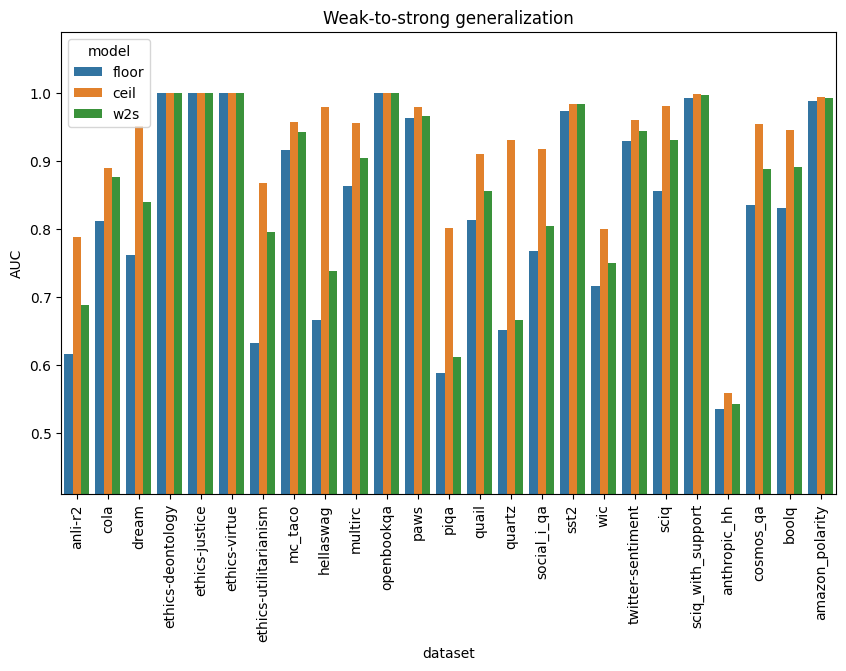

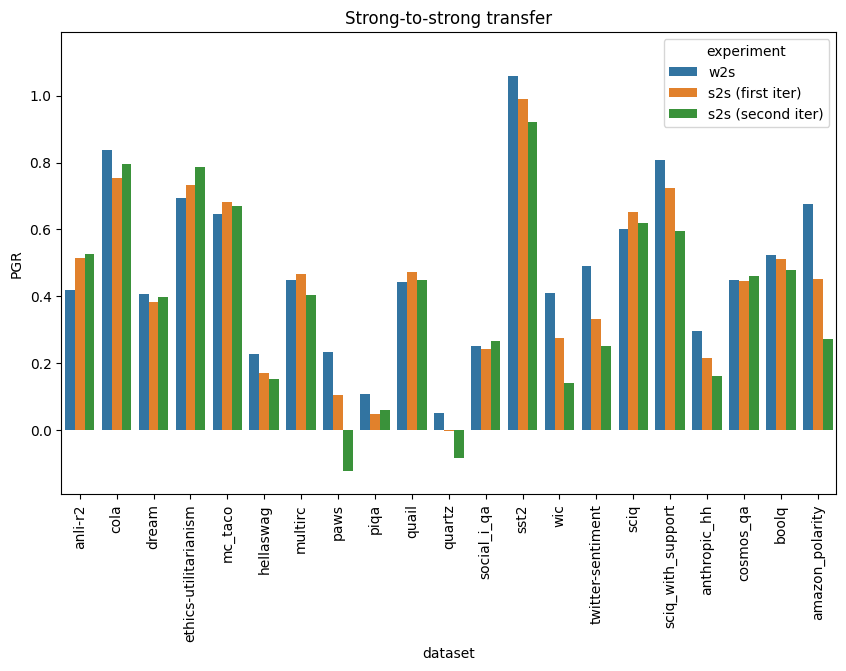

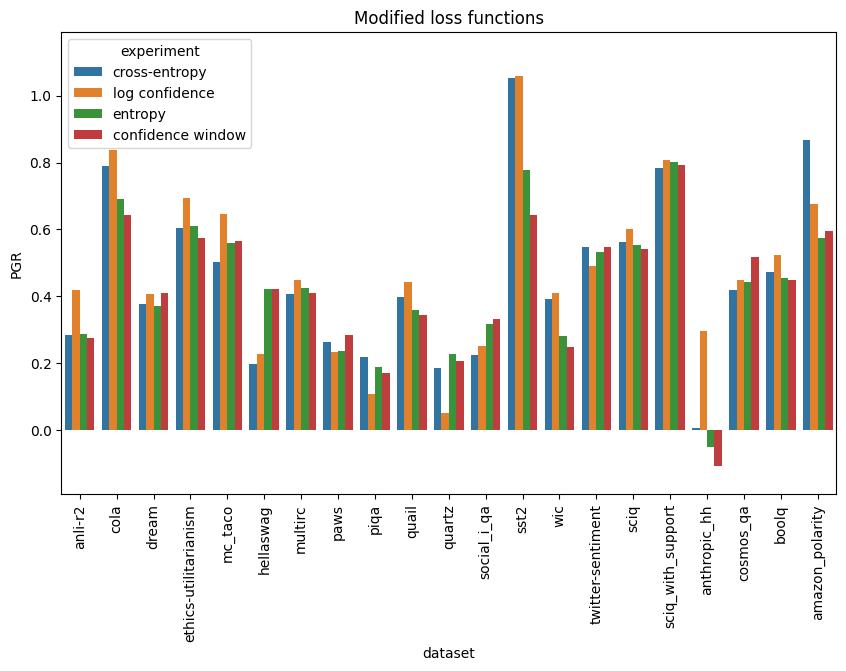

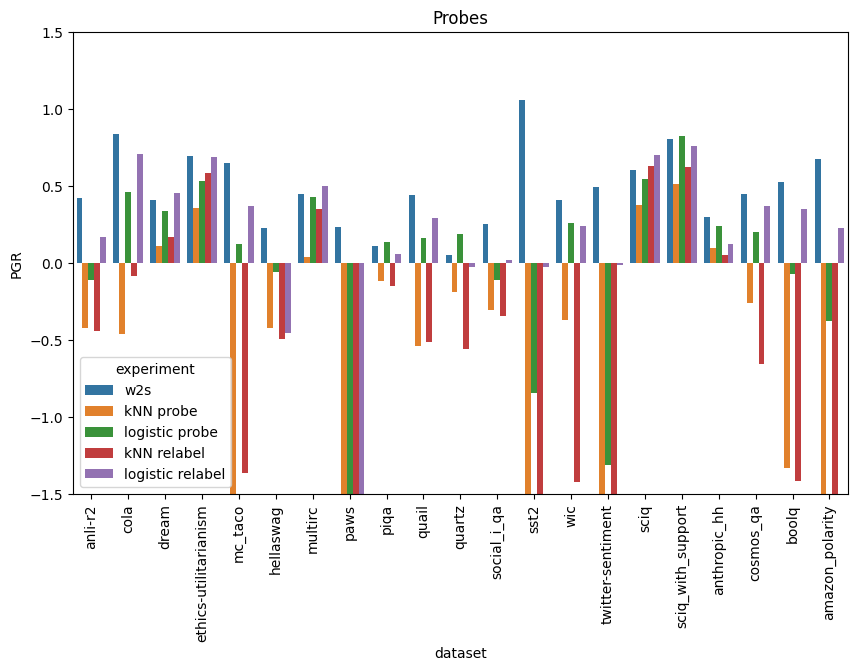

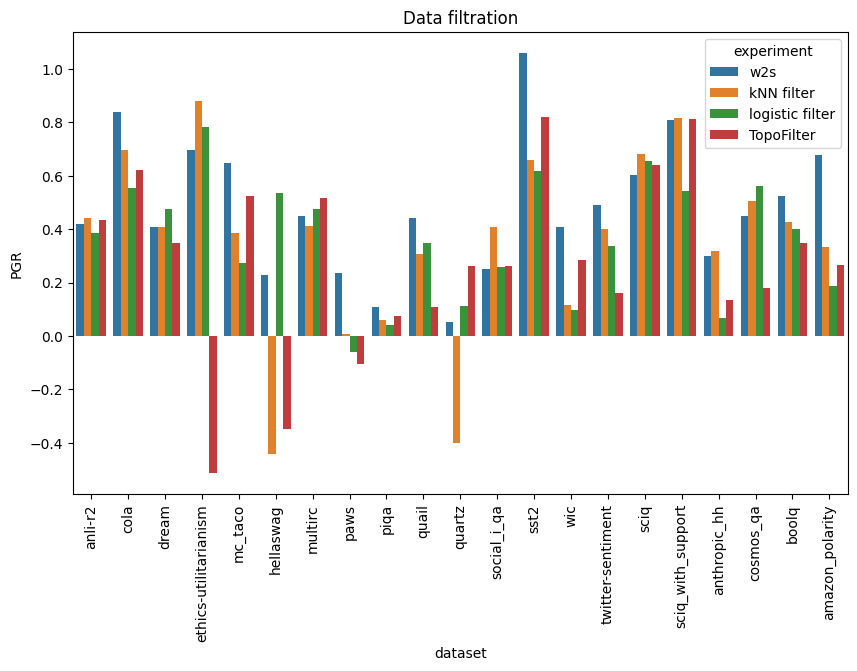

In [40]:
import pandas as pd
import seaborn as sns

all_aucs = {ds: get_pgrs(ds)[1] for ds in datasets}

mydata = [[k, ds, v] for ds, aucs in all_aucs.items() for k, v in aucs.items()]

df = pd.DataFrame(mydata, columns=['model', 'dataset', 'AUC'])

# plot with seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='dataset', y='AUC', hue='model')
plt.xticks(rotation=90)
plt.ylim(.41, 1.09)
plt.title("Weak-to-strong generalization")
plt.show()



#all_pgrs = {ds: get_pgrs(ds)[0] for ds in datasets if ds not in ['ethics-deontology', 'ethics-justice', 'ethics-virtue', 'openbookqa']}
# NB modified below in 'probe aucs' to include direct probe results

def plot_tasks(tasks, title="PGR", ylim=(-.19, 1.19)):
    mydata = [[tasks[k], ds, pgrs[k]] for ds, pgrs in all_pgrs.items() for k in tasks]

    df = pd.DataFrame(mydata, columns=['experiment', 'dataset', 'PGR'])

    # plot with seaborn barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='dataset', y='PGR', hue='experiment')
    plt.xticks(rotation=90)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.title(title)
    plt.show()

plot_tasks({
    'w2s': 'w2s',
    's2s-0': 's2s (first iter)',
    's2s-1': 's2s (second iter)',
}, title="Strong-to-strong transfer")
plot_tasks({
    'xent': 'cross-entropy',
    'w2s': 'log confidence',
    'entropy': 'entropy',
    'window_mid': 'confidence window',
}, title="Modified loss functions")
plot_tasks({
    'w2s': 'w2s',
    'direct_knn': 'kNN probe',
    'direct_logreg': 'logistic probe',
    'probe_knn': 'kNN relabel',
    'probe_logreg': 'logistic relabel',
}, title="Probes", ylim=(-1.5, 1.5))
plot_tasks({
    'w2s': 'w2s',
    'filter_knn': 'kNN filter',
    'filter_logreg': 'logistic filter',
    'filter_topo': 'TopoFilter',
}, title="Data filtration", ylim=None)


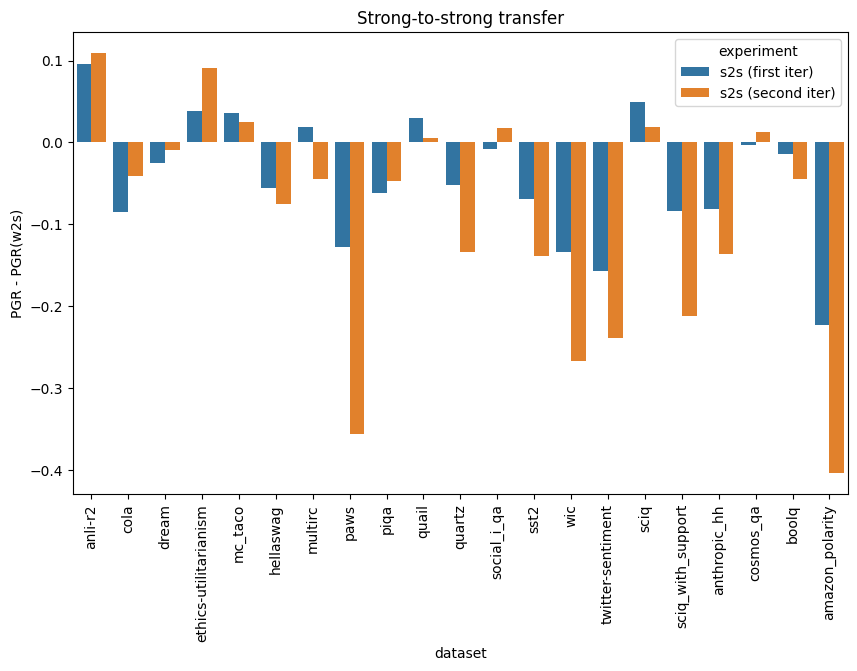

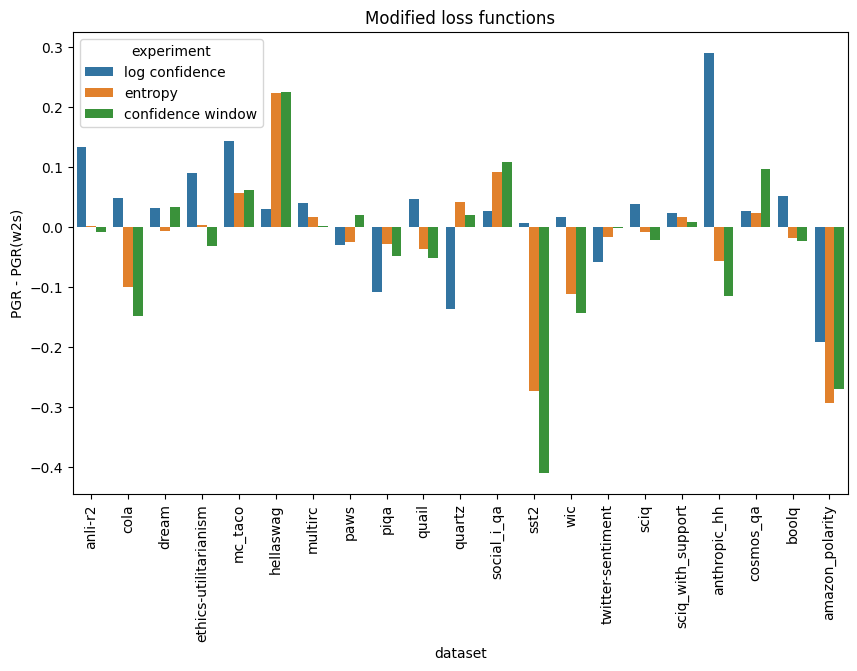

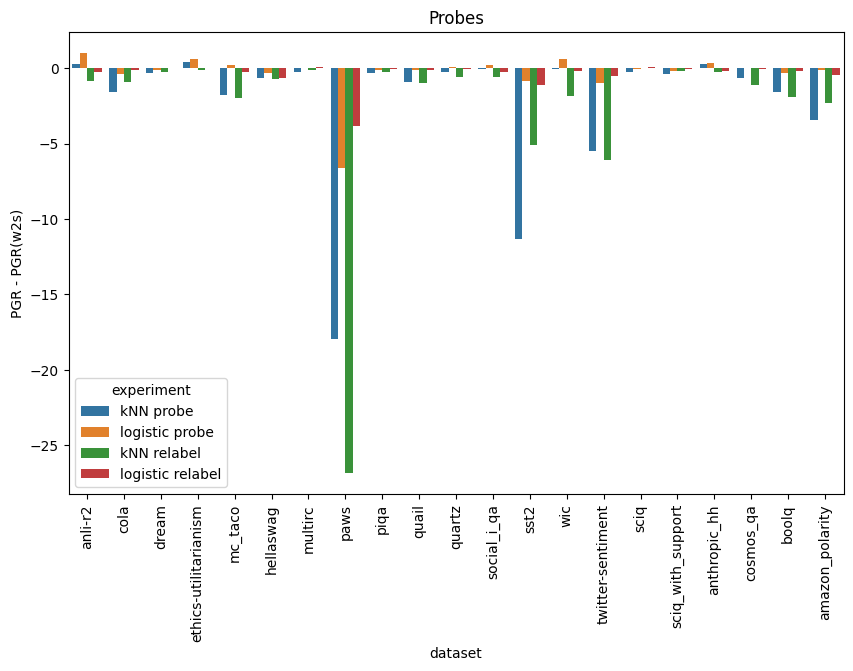

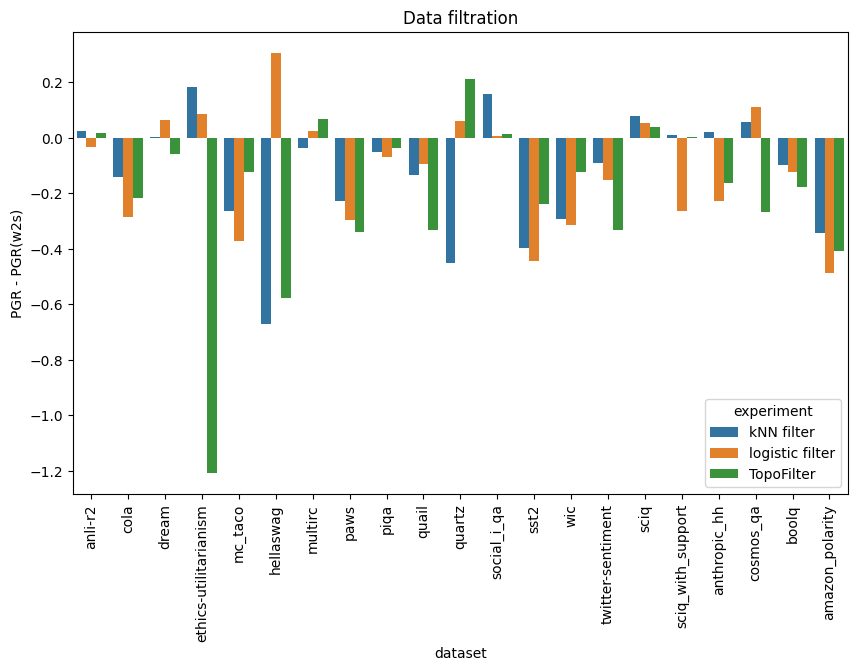

In [35]:
def plot_delta_tasks(tasks, title="PGR", ylim=(-.2,.2), baseline="w2s"):
    mydata = [[tasks[k], ds, pgrs[k] - pgrs[baseline]] for ds, pgrs in all_pgrs.items() for k in tasks]

    df = pd.DataFrame(mydata, columns=['experiment', 'dataset', 'PGR - PGR(w2s)'])

    # plot with seaborn barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='dataset', y='PGR - PGR(w2s)', hue='experiment')
    plt.xticks(rotation=90)
    #plt.ylim(*ylim)
    plt.title(title)
    plt.show()

plot_delta_tasks({
    's2s-0': 's2s (first iter)',
    's2s-1': 's2s (second iter)',
}, title="Strong-to-strong transfer")
plot_delta_tasks({
    'w2s': 'log confidence',
    'entropy': 'entropy',
    'window_mid': 'confidence window',
}, title="Modified loss functions", baseline='xent')
plot_delta_tasks({
    'direct_knn': 'kNN probe',
    'direct_logreg': 'logistic probe',
    'probe_knn': 'kNN relabel',
    'probe_logreg': 'logistic relabel',
}, title="Probes")#, ylim=(-1.5, 1.5))
plot_delta_tasks({
    'filter_knn': 'kNN filter',
    'filter_logreg': 'logistic filter',
    'filter_topo': 'TopoFilter',
}, title="Data filtration")
    

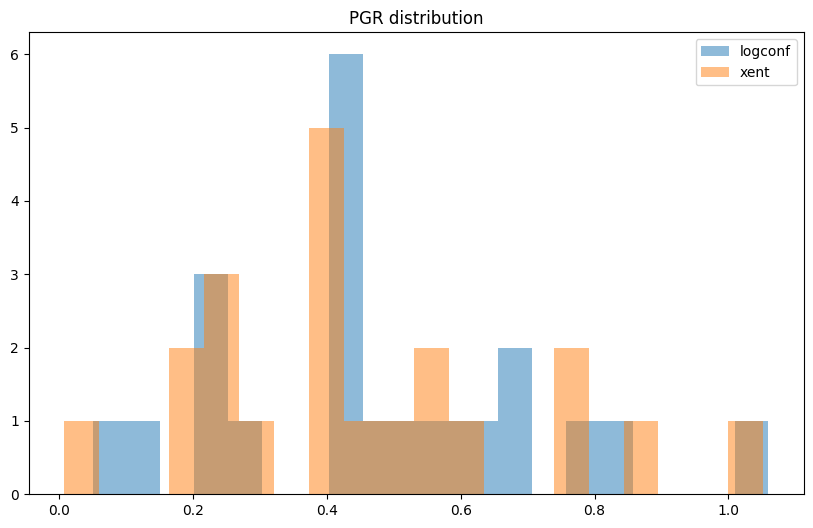

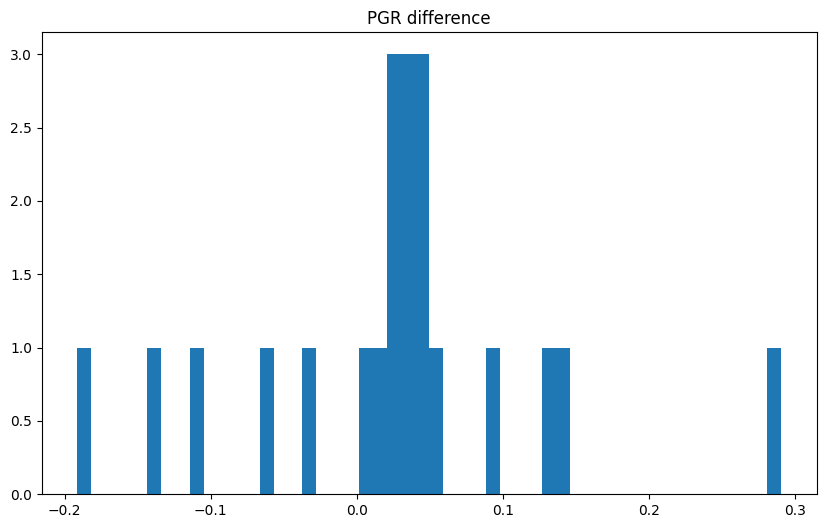

In [36]:
plogconf = [all_pgrs[ds]['w2s'] for ds in all_pgrs]
plogconf = np.array(plogconf)
pxent = [all_pgrs[ds]['xent'] for ds in all_pgrs]
pxent = np.array(pxent)

plt.figure(figsize=(10, 6))
plt.hist(plogconf, bins=20, alpha=0.5, label='logconf')
plt.hist(pxent, bins=20, alpha=0.5, label='xent')
plt.legend(loc='upper right')
plt.title("PGR distribution")
plt.show()

deltas = plogconf - pxent
plt.figure(figsize=(10, 6))
plt.hist(deltas, bins=50)
plt.title("PGR difference")
plt.show()

In [30]:
import scipy.stats as stats

In [41]:
(plogconf > pxent).sum()

16

In [42]:
len(plogconf)

21

In [31]:
stats.ttest_rel(plogconf, pxent, alternative='greater')

TtestResult(statistic=1.1346715225466497, pvalue=0.13496486857523585, df=20)

In [34]:
stats.wilcoxon(plogconf, pxent, alternative='greater')

WilcoxonResult(statistic=157.0, pvalue=0.0785670280456543)

In [37]:
datasets

['anli-r2',
 'cola',
 'dream',
 'ethics-deontology',
 'ethics-justice',
 'ethics-virtue',
 'ethics-utilitarianism',
 'mc_taco',
 'hellaswag',
 'multirc',
 'openbookqa',
 'paws',
 'piqa',
 'quail',
 'quartz',
 'social_i_qa',
 'sst2',
 'wic',
 'twitter-sentiment',
 'sciq',
 'sciq_with_support',
 'anthropic_hh',
 'cosmos_qa',
 'boolq',
 'amazon_polarity']

# probes

In [14]:
from w2s.sft_config import SFTConfig
from w2s.ds_registry import load_and_process_dataset
from datasets import load_from_disk
import torch

In [15]:
from w2s.probe import KnnProbe, KnnProbeConfig, PROBE_CONFIGS, PROBES
from w2s.roc_auc import roc_auc

In [16]:
from importlib import reload
import w2s.probe
reload(w2s.probe)
KnnProbe = w2s.probe.KnnProbe
KnnProbeConfig = w2s.probe.KnnProbeConfig
PROBE_CONFIGS = w2s.probe.PROBE_CONFIGS
PROBES = w2s.probe.PROBES

In [17]:
# datasets = [
#     'boolq',
#     'anli-r2',
#     'cosmos_qa',
#     'mc_taco',
#     'sciq',
#     'paws',
#     'twitter-sentiment',
#     'wic'
#  ]

In [18]:
def xent(target, preds):
    return (-target * torch.log(preds) - (1 - target) * torch.log(1 - preds)).mean()

In [19]:
def shared_dir(ds):
    if ds == 'quartz':
        return 'repro_0613e'
    return 'repro_0610'

## Filter contam

In [43]:
def get_filter_strength(ds, task='filter_knn'):
    # load from test_probe_metrics.json
    date = date_code(ds, task)
    path = f"../results/repro_{date}_{task}/{ds}/w2s/val_filter_sizes.json"
    with open(path) as f:
        dat = json.load(f)

    return dat['removed'] / dat['before']

In [47]:
strengths = {}

for algo in ['knn', 'logreg', 'topo']:
    for ds in all_pgrs:
        strength = get_filter_strength(ds, f'filter_{algo}')
        if strength > .1:
            print(ds, algo, strength)
            strengths[ds] = strength

dream topo 0.153
ethics-utilitarianism topo 0.501
hellaswag topo 0.367
piqa topo 0.307
twitter-sentiment topo 0.111
cosmos_qa topo 0.394
amazon_polarity topo 0.117


In [48]:
strengths

{'dream': 0.153,
 'ethics-utilitarianism': 0.501,
 'hellaswag': 0.367,
 'piqa': 0.307,
 'twitter-sentiment': 0.111,
 'cosmos_qa': 0.394,
 'amazon_polarity': 0.117}

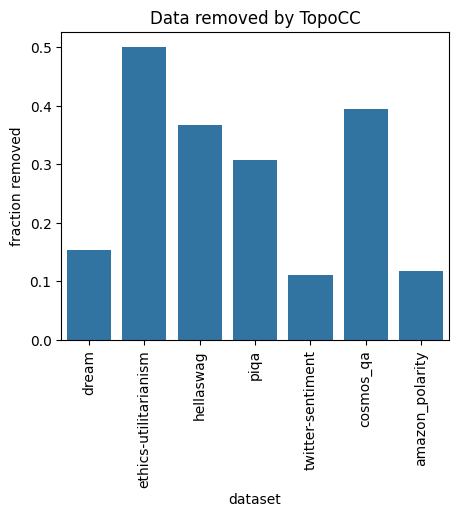

In [51]:
 mydata = [[ds, strength] for ds, strength in strengths.items()]

df = pd.DataFrame(mydata, columns=['dataset', 'fraction removed'])

# plot with seaborn barplot
plt.figure(figsize=(5, 4))
sns.barplot(data=df, x='dataset', y='fraction removed')
plt.xticks(rotation=90)
#plt.ylim(*ylim)
plt.title("Data removed by TopoCC")
plt.show()

## probe aucs

In [38]:
import json

def get_probe_auc(ds, task='probe_knn'):
    # load from test_probe_metrics.json
    date = date_code(ds, task)
    path = f"../results/repro_{date}_{task}/{ds}/w2s/test_probe_metrics.json"
    with open(path) as f:
        metrics = json.load(f)

    return metrics['gt']['auroc']

In [39]:
all_pgrs = {ds: get_pgrs(ds)[0] for ds in datasets if ds not in ['ethics-deontology', 'ethics-justice', 'ethics-virtue', 'openbookqa']}

for ds in all_pgrs:
    for algo in ['knn', 'logreg']:
        auc = get_probe_auc(ds, f'probe_{algo}')
        pgr = compute_pgr(auc, all_aucs[ds]['floor'], all_aucs[ds]['ceil'])
        all_pgrs[ds][f'direct_{algo}'] = pgr

## probe hyparam scans

In [69]:
def load_act(dataset, layer):
    acts_dir = f"../results/{shared_dir(dataset)}/{dataset}/w2s/activations/"
    print(f"Loading activations for {dataset}...", flush=True)
    acts = torch.load(acts_dir + f"train_{layer}.pt", map_location="cpu")
    print("Activations loaded", flush=True)

    return acts

In [70]:
%%time

all_acts = {}

for layer in [6, 16, 26, 31]:
    for ds in datasets:
        act = load_act(ds, layer)
        all_acts[(ds, layer)] = act

Loading activations for anli-r2...
Activations loaded
Loading activations for cola...
Activations loaded
Loading activations for dream...
Activations loaded
Loading activations for ethics-deontology...
Activations loaded
Loading activations for ethics-justice...
Activations loaded
Loading activations for ethics-virtue...
Activations loaded
Loading activations for ethics-utilitarianism...
Activations loaded
Loading activations for mc_taco...
Activations loaded
Loading activations for hellaswag...
Activations loaded
Loading activations for multirc...
Activations loaded
Loading activations for openbookqa...
Activations loaded
Loading activations for paws...
Activations loaded
Loading activations for piqa...
Activations loaded
Loading activations for quail...
Activations loaded
Loading activations for quartz...
Activations loaded
Loading activations for social_i_qa...
Activations loaded
Loading activations for sst2...
Activations loaded
Loading activations for wic...
Activations loaded
Loa

In [63]:
[*all_acts.keys()]

['anli-r2',
 'cola',
 'dream',
 'ethics-deontology',
 'ethics-justice',
 'ethics-virtue',
 'ethics-utilitarianism',
 'mc_taco',
 'hellaswag',
 'multirc',
 'openbookqa',
 'paws',
 'piqa',
 'quail',
 'quartz',
 'social_i_qa',
 'sst2',
 'wic',
 'twitter-sentiment',
 'sciq',
 'sciq_with_support',
 'anthropic_hh',
 'cosmos_qa',
 'boolq',
 'amazon_polarity']

In [57]:
datasets = VALID_DATASETS.copy()
# datasets.remove('quartz')
datasets.remove('amazon_polarity_gt')
datasets.remove('amazon_polarity_weak')

In [58]:
loaded_datasets = {
    ds: load_and_process_dataset(
        ds, 10_000, 1_000, 5_000, 0
    )
    for ds in datasets
}

anli-r2 has < 5000 docs after balancing, using all 668
cola has < 11000 docs after balancing, using all 5056
cola has < 5000 docs after balancing, using all 644


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for dream contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dream
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


dream has < 11000 docs after balancing, using all 6082
dream has < 5000 docs after balancing, using all 1984
ethics-deontology has < 5000 docs after balancing, using all 3526
ethics-justice has < 5000 docs after balancing, using all 2004
ethics-virtue has < 11000 docs after balancing, using all 4830
ethics-virtue has < 5000 docs after balancing, using all 1912
ethics-utilitarianism has < 5000 docs after balancing, using all 4166


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for mc_taco contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mc_taco
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


mc_taco has < 11000 docs after balancing, using all 6396
mc_taco has < 5000 docs after balancing, using all 2458


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/super_glue
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


multirc has < 5000 docs after balancing, using all 4150
openbookqa has < 11000 docs after balancing, using all 4912
openbookqa has < 5000 docs after balancing, using all 472


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for piqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/piqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


piqa has < 5000 docs after balancing, using all 1832
quail has < 11000 docs after balancing, using all 10226
quail has < 5000 docs after balancing, using all 2148
quartz has < 11000 docs after balancing, using all 2666
quartz has < 5000 docs after balancing, using all 764


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for social_i_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/social_i_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


social_i_qa has < 5000 docs after balancing, using all 1888
sst2 has < 5000 docs after balancing, using all 856
wic has < 11000 docs after balancing, using all 5428
wic has < 5000 docs after balancing, using all 638
sciq has < 11000 docs after balancing, using all 10674
sciq has < 5000 docs after balancing, using all 2980
sciq_with_support has < 11000 docs after balancing, using all 10674
sciq_with_support has < 5000 docs after balancing, using all 2980


/home/adam/.local/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for cosmos_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cosmos_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


cosmos_qa has < 5000 docs after balancing, using all 2646
boolq has < 11000 docs after balancing, using all 7106
boolq has < 5000 docs after balancing, using all 2474


In [71]:
def do_things(ds, hyps, layer=16, algo="knn"):
    cfg = SFTConfig(dataset=ds)
    splits = loaded_datasets[ds]
    train_halves = splits["train"].train_test_split(test_size=0.5, seed=42)
    splits["weak_train"] = train_halves["train"]
    splits["strong_train"] = train_halves["test"]

    gt = splits['strong_train']['hard_label']
    gt = [float(x) for x in gt]

    
    prev_preds_root = f"../results/{shared_dir(ds)}/{ds}/weak/predictions/"
    prev_train_preds_ds = load_from_disk(prev_preds_root + "train")
    wk = prev_train_preds_ds["soft_pred"]

    acts = all_acts[ds, layer].cuda()

    wk = torch.tensor(wk, device="cuda")
    gt = torch.tensor(gt, device="cuda")

    aucs = []
    aggs = []
    hyp, hyp_vals = hyps[algo]

    print(f"Running {algo} on {ds} at layer {layer}...")

    for v in hyp_vals:
        probe = PROBES[algo](PROBE_CONFIGS[algo](**{hyp: v}))

        probe.fit(acts, wk)
        preds = probe.predict(acts)

        auc_gt = roc_auc(gt, preds)
        agg_wk = xent(wk, preds)

        aucs.append(auc_gt.cpu().item())
        aggs.append(agg_wk.cpu().item())

    print(f"Done with {algo} on {ds}")

    baseline = roc_auc(gt, wk).cpu().item()

    # plt.plot(ks, aucs)
    # plt.axhline(baseline, color="red")
    # plt.show()
    # plt.plot(ks, xents)
    # plt.show()

    return aucs, aggs, baseline

In [60]:
hyps = {
    "knn": ("k", [1, *range(5, 100, 5)]),
    "logreg": ("l2p", [10**x for x in range(-5, 1)]),
}

Running knn on boolq with k...
Done with knn on boolq
Running knn on anli-r2 with k...
Done with knn on anli-r2
Running knn on cosmos_qa with k...
Done with knn on cosmos_qa
Running knn on mc_taco with k...
Done with knn on mc_taco
Running knn on sciq with k...
Done with knn on sciq
Running knn on paws with k...
Done with knn on paws
Running knn on twitter-sentiment with k...
Done with knn on twitter-sentiment
Running knn on wic with k...
Done with knn on wic
Running knn on boolq with k...
Done with knn on boolq
Running knn on anli-r2 with k...
Done with knn on anli-r2
Running knn on cosmos_qa with k...
Done with knn on cosmos_qa
Running knn on mc_taco with k...
Done with knn on mc_taco
Running knn on sciq with k...
Done with knn on sciq
Running knn on paws with k...
Done with knn on paws
Running knn on twitter-sentiment with k...
Done with knn on twitter-sentiment
Running knn on wic with k...
Done with knn on wic
Running knn on boolq with k...
Done with knn on boolq
Running knn on anl

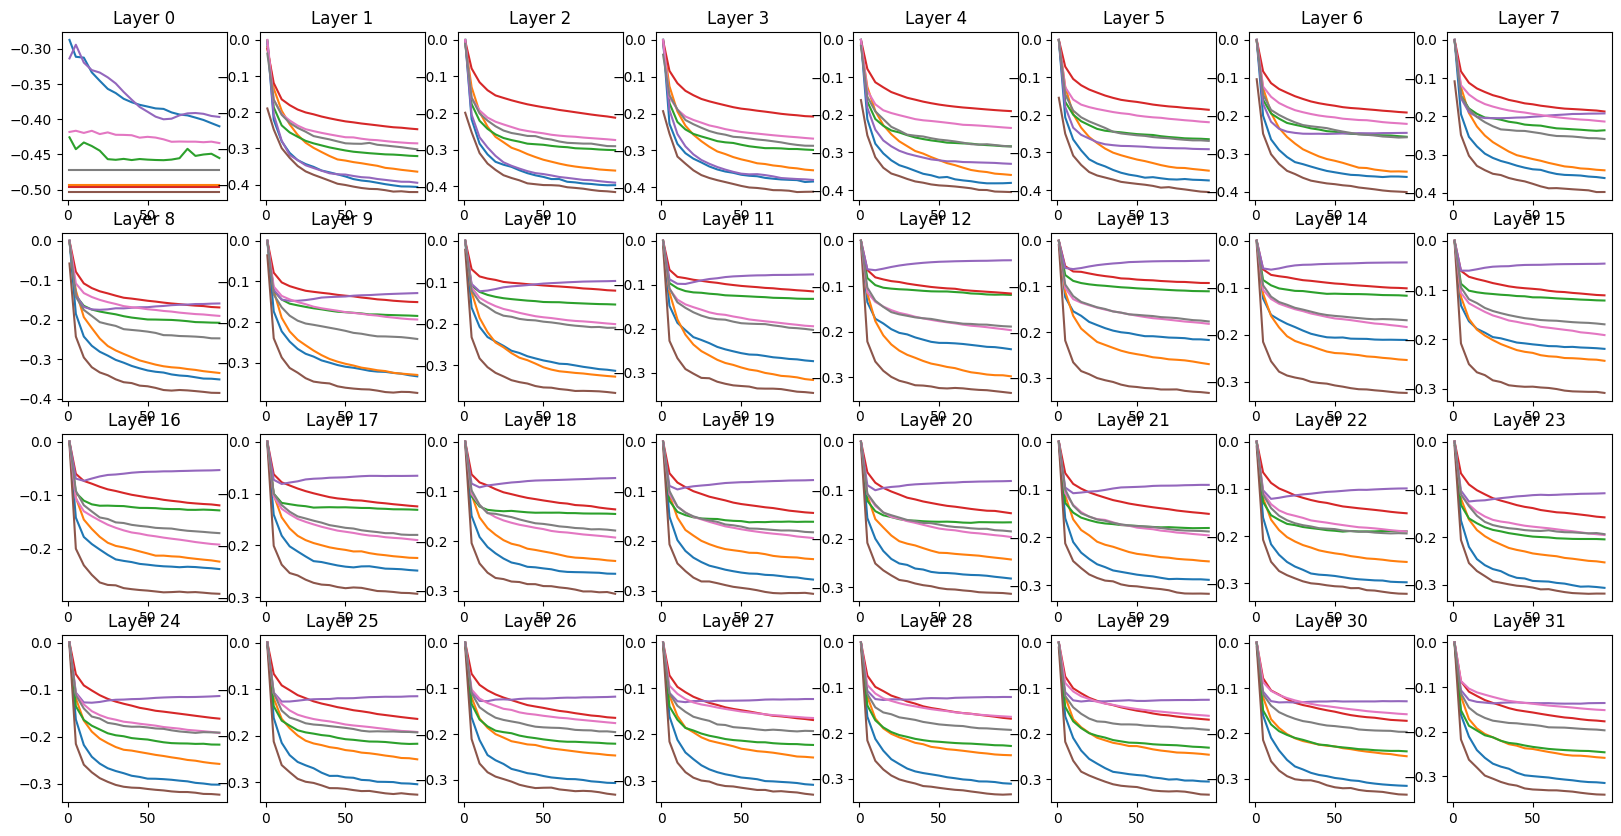

In [50]:
h, w = 4, 8
fig, axs = plt.subplots(h, w, figsize=(20, 10))
for layer in range(32):
    i, j = layer // w, layer % w
    ax = axs[i, j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="knn", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['knn'][1], delta_aucs)

    ax.set_title(f"Layer {layer}")
plt.show()

Running knn on anli-r2 at layer 6...
Done with knn on anli-r2
Running knn on cola at layer 6...
Done with knn on cola
Running knn on dream at layer 6...
Done with knn on dream
Running knn on ethics-deontology at layer 6...
Done with knn on ethics-deontology
Running knn on ethics-justice at layer 6...
Done with knn on ethics-justice
Running knn on ethics-virtue at layer 6...
Done with knn on ethics-virtue
Running knn on ethics-utilitarianism at layer 6...
Done with knn on ethics-utilitarianism
Running knn on mc_taco at layer 6...
Done with knn on mc_taco
Running knn on hellaswag at layer 6...
Done with knn on hellaswag
Running knn on multirc at layer 6...
Done with knn on multirc
Running knn on openbookqa at layer 6...
Done with knn on openbookqa
Running knn on paws at layer 6...
Done with knn on paws
Running knn on piqa at layer 6...
Done with knn on piqa
Running knn on quail at layer 6...
Done with knn on quail
Running knn on quartz at layer 6...
Done with knn on quartz
Running knn on

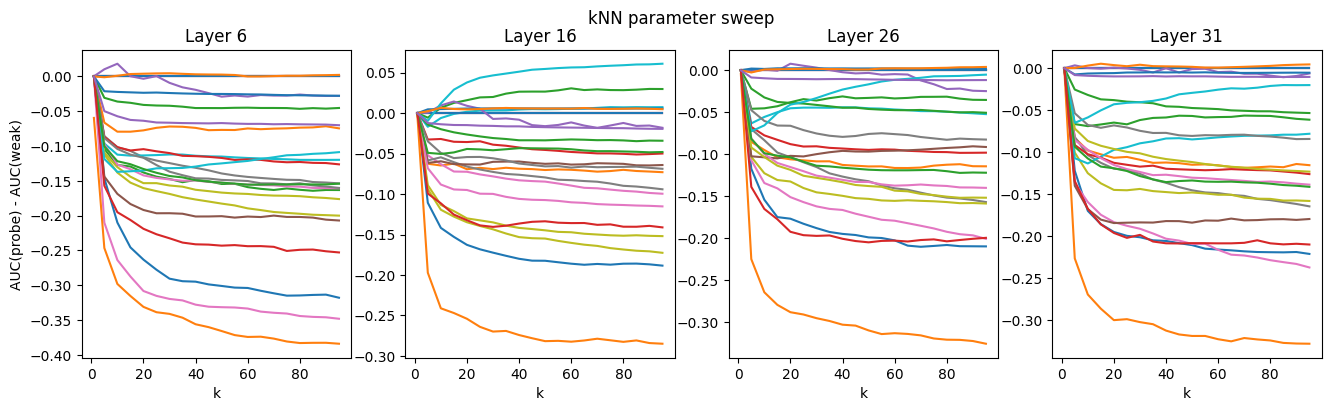

In [76]:
h, w = 1, 4
fig, axs = plt.subplots(h, w, figsize=(16, 4))
for n, layer in enumerate([6, 16, 26, 31]):
    i, j = n // w, n % w
    ax = axs[j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="knn", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['knn'][1], delta_aucs)

    ax.set_title(f"Layer {layer}")
    ax.set_xlabel(hyps['knn'][0])
    if n == 0:
        ax.set_ylabel("AUC(probe) - AUC(weak)")
fig.suptitle('kNN parameter sweep')
plt.show()

Running logreg on anli-r2 at layer 6...
Done with logreg on anli-r2
Running logreg on cola at layer 6...
Done with logreg on cola
Running logreg on dream at layer 6...
Done with logreg on dream
Running logreg on ethics-deontology at layer 6...
Done with logreg on ethics-deontology
Running logreg on ethics-justice at layer 6...
Done with logreg on ethics-justice
Running logreg on ethics-virtue at layer 6...
Done with logreg on ethics-virtue
Running logreg on ethics-utilitarianism at layer 6...
Done with logreg on ethics-utilitarianism
Running logreg on mc_taco at layer 6...
Done with logreg on mc_taco
Running logreg on hellaswag at layer 6...
Done with logreg on hellaswag
Running logreg on multirc at layer 6...
Done with logreg on multirc
Running logreg on openbookqa at layer 6...
Done with logreg on openbookqa
Running logreg on paws at layer 6...
Done with logreg on paws
Running logreg on piqa at layer 6...
Done with logreg on piqa
Running logreg on quail at layer 6...
Done with logreg

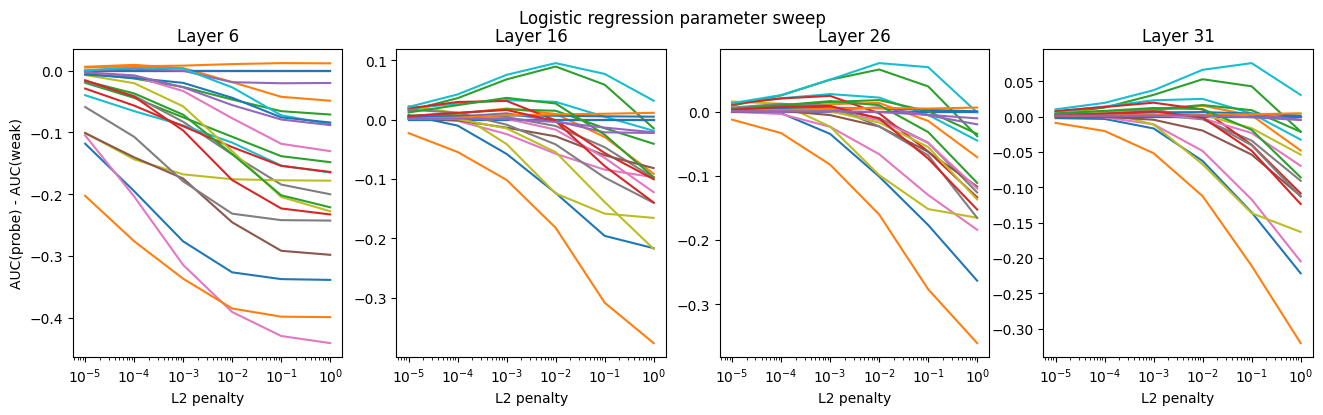

In [78]:
h, w = 1, 4
fig, axs = plt.subplots(h, w, figsize=(16, 4))
for n, layer in enumerate([6, 16, 26, 31]):
    i, j = n // w, n % w
    ax = axs[j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="logreg", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['logreg'][1], delta_aucs)

    ax.set_xscale('log')
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("L2 penalty")
    if n == 0:
        ax.set_ylabel("AUC(probe) - AUC(weak)")
fig.suptitle('Logistic regression parameter sweep')
plt.show()

Running logreg on anli-r2 at layer 5...
Done with logreg on anli-r2
Running logreg on cola at layer 5...
Done with logreg on cola
Running logreg on dream at layer 5...
Done with logreg on dream
Running logreg on ethics-deontology at layer 5...
Done with logreg on ethics-deontology
Running logreg on ethics-justice at layer 5...
Done with logreg on ethics-justice
Running logreg on ethics-virtue at layer 5...
Done with logreg on ethics-virtue
Running logreg on ethics-utilitarianism at layer 5...
Done with logreg on ethics-utilitarianism
Running logreg on mc_taco at layer 5...
Done with logreg on mc_taco
Running logreg on hellaswag at layer 5...
Done with logreg on hellaswag
Running logreg on multirc at layer 5...
Done with logreg on multirc
Running logreg on openbookqa at layer 5...
Done with logreg on openbookqa
Running logreg on paws at layer 5...
Done with logreg on paws
Running logreg on piqa at layer 5...
Done with logreg on piqa
Running logreg on quail at layer 5...
Done with logreg

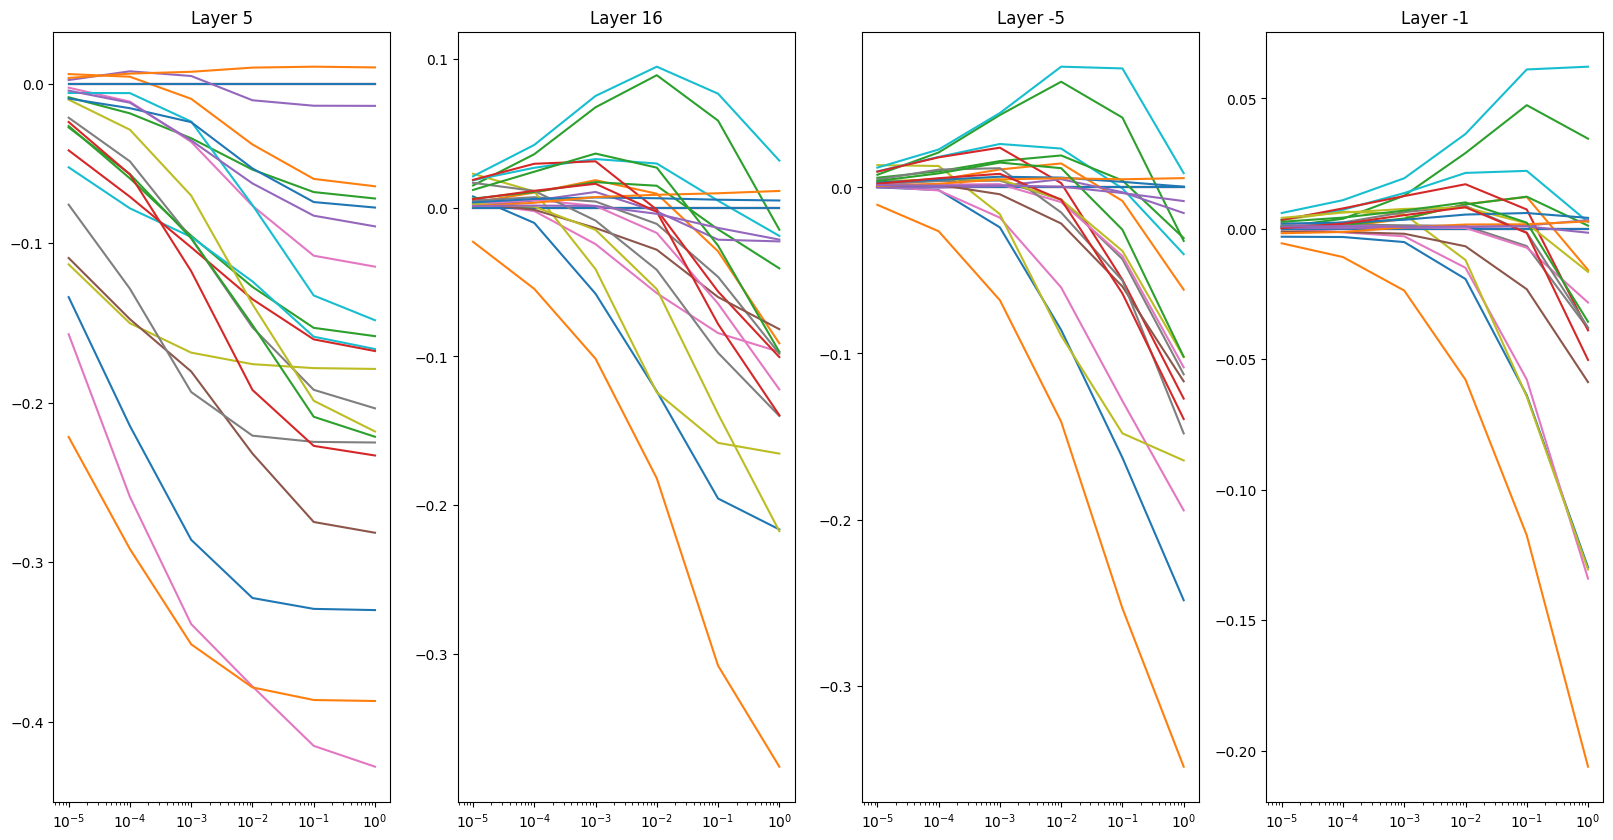

In [ ]:
h, w = 1, 4
fig, axs = plt.subplots(h, w, figsize=(16, 4))
for n, layer in enumerate([6, 16, 26, 31]):
    i, j = n // w, n % w
    ax = axs[j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="logreg", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['logreg'][1], delta_aucs)

    ax.set_xscale('log')
    ax.set_title(f"Layer {layer}")
plt.show()

Running logreg on anli-r2 at layer 5...
Done with logreg on anli-r2
Running logreg on cola at layer 5...
Done with logreg on cola
Running logreg on dream at layer 5...
Done with logreg on dream
Running logreg on ethics-deontology at layer 5...
Done with logreg on ethics-deontology
Running logreg on ethics-justice at layer 5...
Done with logreg on ethics-justice
Running logreg on ethics-virtue at layer 5...
Done with logreg on ethics-virtue
Running logreg on ethics-utilitarianism at layer 5...
Done with logreg on ethics-utilitarianism
Running logreg on mc_taco at layer 5...
Done with logreg on mc_taco
Running logreg on hellaswag at layer 5...
Done with logreg on hellaswag
Running logreg on multirc at layer 5...
Done with logreg on multirc
Running logreg on openbookqa at layer 5...
Done with logreg on openbookqa
Running logreg on paws at layer 5...
Done with logreg on paws
Running logreg on piqa at layer 5...
Done with logreg on piqa
Running logreg on quail at layer 5...
Done with logreg

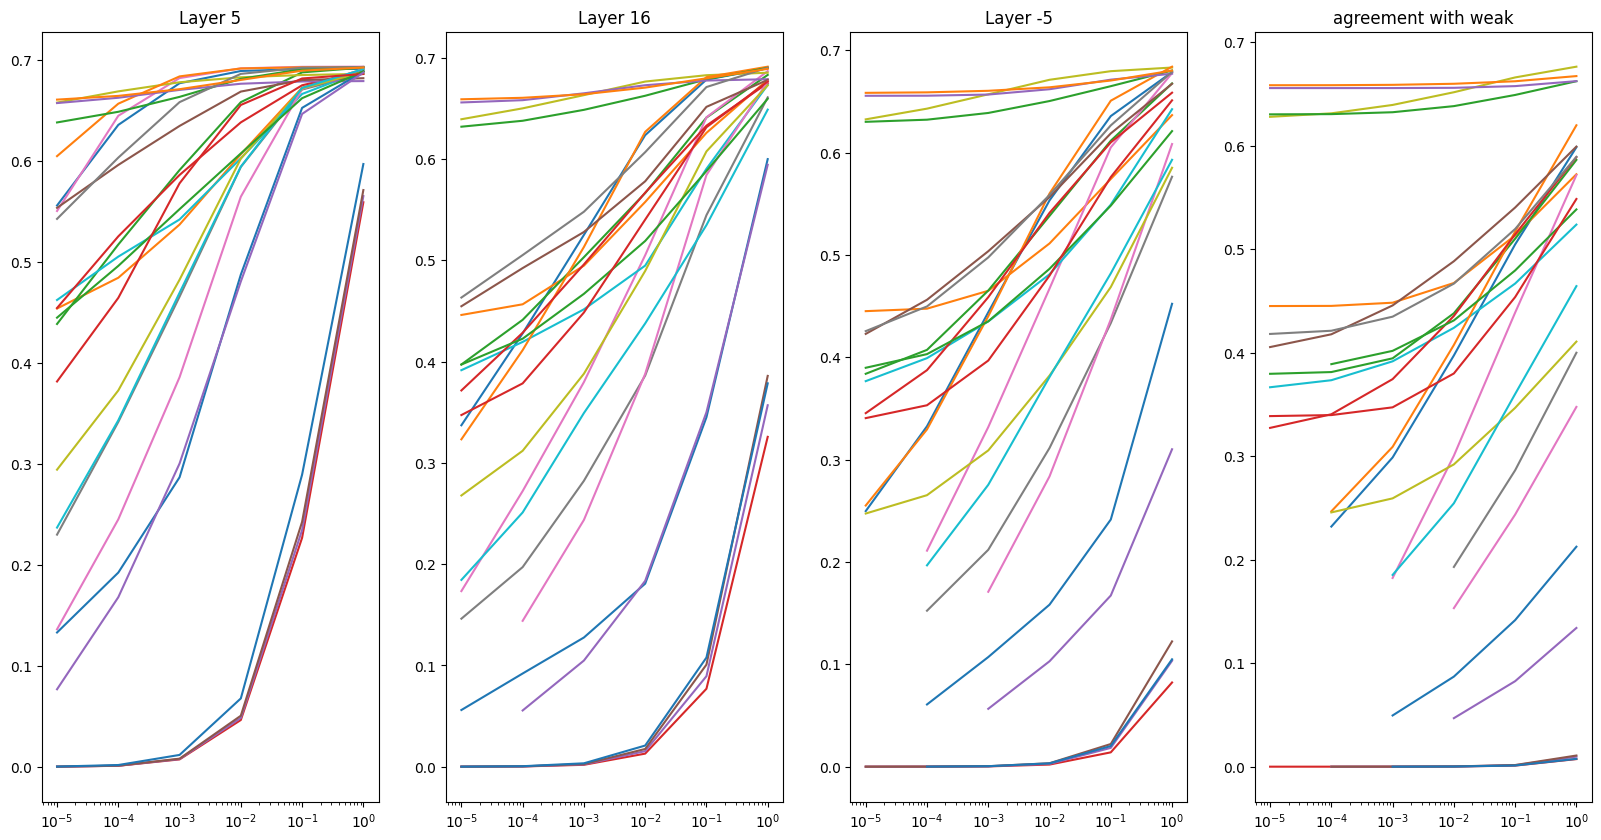

In [79]:
h, w = 1, 4
fig, axs = plt.subplots(h, w, figsize=(20, 10))
for n, layer in enumerate([5, 16, -5, -1]):
    i, j = n // w, n % w
    ax = axs[j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="logreg", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['logreg'][1], aggs)

    ax.set_xscale('log')
    ax.set_title(f"Layer {layer}")
plt.title("agreement with weak")
plt.show()

In [63]:
h, w = 4, 8
fig, axs = plt.subplots(h, w, figsize=(20, 10))
for layer in range(32):
    i, j = layer // w, layer % w
    ax = axs[i, j]
    for ds in datasets:
        aucs, aggs, baseline = do_things(ds, hyps, algo="logreg", layer=layer)
        delta_aucs = [auc - baseline for auc in aucs]
        ax.plot(hyps['logreg'][1], delta_aucs)
    # semilog on x
    ax.set_xscale('log')

    ax.set_title(f"Layer {layer}")
plt.show()

Running logreg on boolq at layer 0...
Done with logreg on boolq
Running logreg on anli-r2 at layer 0...
Done with logreg on anli-r2
Running logreg on cosmos_qa at layer 0...
Done with logreg on cosmos_qa
Running logreg on mc_taco at layer 0...
Done with logreg on mc_taco
Running logreg on sciq at layer 0...
Done with logreg on sciq
Running logreg on paws at layer 0...
Done with logreg on paws
Running logreg on twitter-sentiment at layer 0...
Done with logreg on twitter-sentiment
Running logreg on wic at layer 0...
Done with logreg on wic
Running logreg on boolq at layer 1...
Done with logreg on boolq
Running logreg on anli-r2 at layer 1...
Done with logreg on anli-r2
Running logreg on cosmos_qa at layer 1...
Done with logreg on cosmos_qa
Running logreg on mc_taco at layer 1...
Done with logreg on mc_taco
Running logreg on sciq at layer 1...
Done with logreg on sciq
Running logreg on paws at layer 1...
Done with logreg on paws
Running logreg on twitter-sentiment at layer 1...
Done with 